# 用Python进行潮流计算和功率分配优化

## 前推回代法潮流计算

所谓前推回代法，只适用于树形网络，一般是配电网。反映到数据结构里就是树的遍历，从叶到根，再从根到叶。

下面的代码**Looks like sh\*t**，但它确实能用并且具有通用性。

算例使用何书`例题11-1`，前推使用循环，回代用到了递归。

In [1]:
class node():
    def __init__(self, index, voltage, load, receive_from, send_through):
        self.index = index
        self.receive_from = receive_from
        self.send_through = send_through
        self.send_through_for_iter = self.send_through.copy()
        self.load = load
        self.voltage = voltage
        self.received_power = load
    def update_power_flow(self):
        self.received_power = self.load\
            +sum([each.transfer_power for each in self.send_through])
    def reset(self):
        self.send_through_for_iter = self.send_through.copy()
    def update_voltage(self,net , current_edge):
        self.voltage = abs(net[current_edge.source_node_index-1].voltage\
                       - current_edge.voltage_loss)

class edge():
    def __init__(self, impedance, connect_to):
        self.impedance = impedance
        self.source_node_index = connect_to[0]
        self.user_node_index = connect_to[1]
        self.power_loss = 0
        self.voltage_loss = 0
        self.transfer_power = 0
    def update_power_flow(self, net):
        send_power = net[self.user_node_index-1].received_power
        voltage = net[self.user_node_index-1].voltage
        self.power_loss = self.impedance * abs(send_power/voltage)**2
        self.transfer_power = self.power_loss + send_power
    def update_voltage(self, voltage):
        self.voltage_loss = self.transfer_power\
             * self.impedance.conjugate() / voltage

edge1 = edge(0.54+0.65j,[1,2])
edge2 = edge(0.62+0.5j,[2,3])
edge3 = edge(0.6+0.35j,[3,4])
edge4 = edge(0.72+0.75j,[2,5])
edge5 = edge(1.0+0.55j,[5,6])
edge6 = edge(0.65+0.35j,[5,7])
edge7 = edge(0.9+0.5j,[2,8])
edges = [edge1,edge2,edge3,edge4,edge5,edge6,edge7]

node1 = node(1,10.5,0, None , {edge1})
node2 = node(2,10.5,(0.6+0.45j), edge1, {edge2,edge4,edge7})
node3 = node(3,10.5,(0.4+0.3j), edge2, {edge3})
node4 = node(4,10.5,(0.4+0.28j), edge3, set())
node5 = node(5,10,(0.6+0.4j), edge4, {edge5,edge6})
node6 = node(6,10,(0.4+0.3j), edge5, set())
node7 = node(7,10,(0.5+0.4j), edge6, set())
node8 = node(8,10,(0.5+0.35j), edge7, set())
nodes = [node1,node2,node3,node4,node5,node6,node7,node8]
leaf_node = [each for each in nodes if not each.send_through]

def update_voltage(source_node,current_edge,current_node):
    current_edge.update_voltage(source_node.voltage)
    current_node.update_voltage(nodes, current_edge)
    for current_edge in current_node.send_through_for_iter:
        source_node = current_node
        current_node = nodes[current_edge.user_node_index-1]
        update_voltage(source_node,current_edge,current_node)

iter_count = 0
while True:
    V = [each.voltage for each in nodes]
    S = [each.transfer_power for each in edges]
    nodeiter = leaf_node.copy()
    current_node = nodeiter.pop()
    while True:
        current_edge = current_node.receive_from
        source_node = nodes[current_edge.source_node_index-1]
        current_edge.update_power_flow(nodes)
        source_node.update_power_flow()
        source_node.send_through_for_iter.remove(current_edge)
        if source_node.send_through_for_iter:
            try:current_node = nodeiter.pop()
            except:print('unexpected iteration error.')
        elif source_node.receive_from:
            current_node = source_node
        else:
            for each in nodes:
                each.reset()
            break
    update_voltage(source_node,current_edge,current_node)
    if max([abs(vn - vn_1) for vn,vn_1 in\
            zip([each.voltage for each in nodes], V)])>1e-6:
        iter_count += 1
        if iter_count > 50:print('该系统不收敛');break
    else:
        V = [each.voltage for each in nodes]
        S = [each.transfer_power for each in edges]
        break
print('每个节点电压：\n',V)
print('每条支路功率：\n',S)

每个节点电压：
 [10.5, 10.15558955732597, 10.075950820975375, 10.042292782778716, 9.962567971028836, 9.90552582743957, 9.915398742359878, 10.093667504909464]
每条支路功率：
 [(3.536373162773606+2.6312017514466137j), (0.807400874555281+0.5856519813407112j), (0.40141837720288814+0.2808273867016848j), (1.5305184990611447+1.1291733546484828j), (0.4025479150146329+0.30140135325804807j), (0.5027106712184759+0.40145959219456395j), (0.5032905674433167+0.3518280930240648j)]


## 水火电厂功率的经济分配

算例使用何书`例题14-4`，这个程序不具有通用性。

In [2]:
import sympy as s
s.init_printing(use_unicode=True, wrap_line=True,print_builtin=False)
s.var('P_T,P_H,gamma,P_LD')

In [3]:
F = 3 + 0.4*P_T + 0.00035*P_T**2
W = 2 + 0.8*P_H + 0.0015*P_H**2
dFdp = s.diff(F,P_T)
dWdp = s.diff(W,P_H)

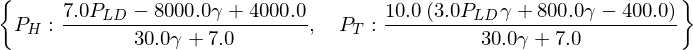

In [4]:
load_dist = s.solve([dFdp - gamma*dWdp, P_T + P_H - P_LD],[P_T, P_H])
load_dist

In [5]:
def W_sum(g):
    ph = [load_dist[P_H].subs({P_LD:pld,gamma:g}) \
          for pld in [350,700,500]]
    return sum(W.subs({P_H:p}) * 3600 * interval \
               for p,interval in zip(ph,[8,10,6]))

In [6]:
_gamma = [0.46, 0.54]
while True:
    res = W_sum(sum(_gamma) / 2)
    _gamma[bool(res < 1.5e7)] = sum(_gamma) / 2
    if abs(res - 1.5e7) < 100:break

In [7]:
import pandas as pd
g = sum(_gamma) / 2
index = ['0~8h','8~18','18~24']
pd.DataFrame({'$P_{LD}$':[350,700,500],
              '$P_H$':[load_dist[P_H].subs({P_LD:pld,gamma:g}) for pld in [350,700,500]],
              '$P_T$':[load_dist[P_T].subs({P_LD:pld,gamma:g}) for pld in [350,700,500]],},
             index = index)

,$P_{LD}$,$P_H$,$P_T$
0~8h,350,104.204835201205,245.795164798795
8~18,700,213.459566212382,486.540433787618
18~24,500,151.028291348853,348.971708651147


In [8]:
W_sum(g)

### 运行结果

$\gamma = 0.5141552734375$

$W_{\Sigma} = 14999715.8813392$

功率分配：
<style scoped="">
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table class="dataframe" border="1">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-72-Frame" tabindex="0" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>P</mi><mi>H</mi></msub></math>" style="position: relative;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1450" role="math" style="width: 1.256em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.238em; height: 0px;"><span style="position: absolute; clip: rect(1.386em, 1001.24em, 2.626em, -1000em); top: -2.257em; left: 0em;"><span class="mrow" id="MathJax-Span-1451"><span class="msubsup" id="MathJax-Span-1452"><span style="display: inline-block; position: relative; width: 1.23em; height: 0px;"><span style="position: absolute; clip: rect(3.133em, 1000.61em, 4.223em, -1000em); top: -4.005em; left: 0em;"><span class="mi" id="MathJax-Span-1453" style="font-family: STIXMathJax_Main; font-style: italic;">P</span><span style="display: inline-block; width: 0px; height: 4.005em;"></span></span><span style="position: absolute; top: -3.855em; left: 0.611em;"><span class="mi" id="MathJax-Span-1454" style="font-size: 70.7%; font-family: STIXMathJax_Main; font-style: italic;">H<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.033em;"></span></span><span style="display: inline-block; width: 0px; height: 4.005em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.257em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.223em; border-left: 0px solid; width: 0px; height: 0.949em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>P</mi><mi>H</mi></msub></math></span></span><script type="math/tex" id="MathJax-Element-72">P_H</script></th>
      <th><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-73-Frame" tabindex="0" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>P</mi><mi>T</mi></msub></math>" style="position: relative;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1455" role="math" style="width: 1.183em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.165em; height: 0px;"><span style="position: absolute; clip: rect(1.386em, 1001.17em, 2.626em, -1000em); top: -2.257em; left: 0em;"><span class="mrow" id="MathJax-Span-1456"><span class="msubsup" id="MathJax-Span-1457"><span style="display: inline-block; position: relative; width: 1.134em; height: 0px;"><span style="position: absolute; clip: rect(3.133em, 1000.61em, 4.223em, -1000em); top: -4.005em; left: 0em;"><span class="mi" id="MathJax-Span-1458" style="font-family: STIXMathJax_Main; font-style: italic;">P</span><span style="display: inline-block; width: 0px; height: 4.005em;"></span></span><span style="position: absolute; top: -3.855em; left: 0.611em;"><span class="mi" id="MathJax-Span-1459" style="font-size: 70.7%; font-family: STIXMathJax_Main; font-style: italic;">T<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.054em;"></span></span><span style="display: inline-block; width: 0px; height: 4.005em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.257em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.223em; border-left: 0px solid; width: 0px; height: 0.949em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>P</mi><mi>T</mi></msub></math></span></span><script type="math/tex" id="MathJax-Element-73">P_T</script></th>
      <th><span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-74-Frame" tabindex="0" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><msub><mi>P</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>L</mi><mi>D</mi></mrow></msub></math>" style="position: relative;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1460" role="math" style="width: 1.62em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.602em; height: 0px;"><span style="position: absolute; clip: rect(1.386em, 1001.6em, 2.626em, -1000em); top: -2.257em; left: 0em;"><span class="mrow" id="MathJax-Span-1461"><span class="msubsup" id="MathJax-Span-1462"><span style="display: inline-block; position: relative; width: 1.592em; height: 0px;"><span style="position: absolute; clip: rect(3.133em, 1000.61em, 4.223em, -1000em); top: -4.005em; left: 0em;"><span class="mi" id="MathJax-Span-1463" style="font-family: STIXMathJax_Main; font-style: italic;">P</span><span style="display: inline-block; width: 0px; height: 4.005em;"></span></span><span style="position: absolute; top: -3.855em; left: 0.611em;"><span class="texatom" id="MathJax-Span-1464"><span class="mrow" id="MathJax-Span-1465"><span class="mi" id="MathJax-Span-1466" style="font-size: 70.7%; font-family: STIXMathJax_Main; font-style: italic;">L<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.002em;"></span></span><span class="mi" id="MathJax-Span-1467" style="font-size: 70.7%; font-family: STIXMathJax_Main; font-style: italic;">D</span></span></span><span style="display: inline-block; width: 0px; height: 4.005em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.257em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.223em; border-left: 0px solid; width: 0px; height: 0.949em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>P</mi><mrow class="MJX-TeXAtom-ORD"><mi>L</mi><mi>D</mi></mrow></msub></math></span></span><script type="math/tex" id="MathJax-Element-74">P_{LD}</script></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0~8h</th>
      <td>104.204835201205</td>
      <td>245.795164798795</td>
      <td>350</td>
    </tr>
    <tr>
      <th>8~18</th>
      <td>213.459566212382</td>
      <td>486.540433787618</td>
      <td>700</td>
    </tr>
    <tr>
      <th>18~24</th>
      <td>151.028291348853</td>
      <td>348.971708651147</td>
      <td>500</td>
    </tr>
  </tbody>
</table>